In [16]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
import joblib
import numpy as np
import collections
import random
import matplotlib.pyplot as plt
import torch.optim as optim



In [17]:
# 1. First, the model's class definition must be present in this notebook too.
class SpatioTemporalGNN_v2(nn.Module):
    def __init__(self, num_nodes, lookback_window, forecast_horizon):
        super(SpatioTemporalGNN_v2, self).__init__()
        self.num_nodes = num_nodes
        self.lookback_window = lookback_window
        self.forecast_horizon = forecast_horizon
        self.gcn = GCNConv(1, 64)
        self.dropout1 = nn.Dropout(0.3)
        self.lstm = nn.LSTM(input_size=64 * num_nodes, hidden_size=256, num_layers=2, batch_first=True)
        self.dropout2 = nn.Dropout(0.3)
        self.linear = nn.Linear(256, num_nodes * forecast_horizon)

    def forward(self, x, edge_index):
        gcn_outputs = []
        for t in range(self.lookback_window):
            snapshot = x[:, t, :].unsqueeze(-1)
            batch_gcn_out = [torch.relu(self.gcn(snapshot[i], edge_index)) for i in range(x.size(0))]
            gcn_out_batch_tensor = torch.stack(batch_gcn_out)
            gcn_outputs.append(gcn_out_batch_tensor)

        gcn_sequence = torch.stack(gcn_outputs, dim=1)
        gcn_sequence = self.dropout1(gcn_sequence)
        lstm_input = gcn_sequence.view(x.size(0), self.lookback_window, -1)
        lstm_out, _ = self.lstm(lstm_input)
        last_time_step_out = lstm_out[:, -1, :]
        last_time_step_out = self.dropout2(last_time_step_out)
        output = self.linear(last_time_step_out)
        output = output.view(-1, self.forecast_horizon, self.num_nodes)
        return output

# 2. Load the saved parameters and artifacts
other_params = torch.load('other_params.pth')
num_states = other_params['num_states']
lookback_window = other_params['lookback_window']
forecast_horizon = other_params['forecast_horizon']
edge_index = other_params['edge_index']
X_test_tensor = other_params['X_test_tensor']
state_to_idx = other_params['state_to_idx']
scaler = joblib.load('min_max_scaler')

# 3. Instantiate the model and load the trained weights
model_v2 = SpatioTemporalGNN_v2(num_states, lookback_window, forecast_horizon)
model_v2.load_state_dict(torch.load('gnn_lstm_model_v2.pth'))
model_v2.eval() # Set it to evaluation mode, as we won't be training it further here

print("Model and all necessary artifacts loaded successfully!")

Model and all necessary artifacts loaded successfully!


In [18]:
!ls -lh gnn_lstm_model_v2.pth

-rw-r--r-- 1 root root 13M Aug 15 01:04 gnn_lstm_model_v2.pth


In [19]:
import random

class EpidemicEnv:
    def __init__(self, predictive_model, initial_state, scaler, edge_index, num_states, forecast_horizon):
        self.model = predictive_model
        self.initial_state = initial_state
        self.scaler = scaler
        self.edge_index = edge_index
        self.num_states = num_states
        self.forecast_horizon = forecast_horizon

        # State Space (S): The state is the sequence of recent case data [cite: 155, 156]
        self.state = initial_state.clone().detach() # Shape: (1, lookback_window, num_states)

        # Action Space (A): Discrete set of NPIs [cite: 157, 158]
        # Action 0: No intervention
        # Action 1: Moderate intervention (e.g., mask advisory)
        # Action 2: Strict intervention (e.g., lockdown)
        self.action_space_n = 3

        # Pre-defined socioeconomic costs for each action [cite: 165]
        self.action_costs = {0: 0.0, 1: 0.4, 2: 1.0}

        # Weights for the reward function [cite: 165]
        self.w_infection = 0.7
        self.w_socioeconomic = 0.3

    def reset(self):
        # Reset the environment to the initial state for a new episode
        self.state = self.initial_state.clone().detach()
        return self.state

    def step(self, action):
        # --- Transition Dynamics (P) ---
        # Use the GNN-LSTM to predict the next state [cite: 160, 161]
        self.model.eval()
        with torch.no_grad():
            # The model predicts the next H days. We take the first day as the next state.
            predicted_scaled_forecast = self.model(self.state, self.edge_index)
            next_state_scaled_partial = predicted_scaled_forecast[:, 0, :].unsqueeze(1) # Get first day of forecast

        # Update our state: drop the oldest day and append the new predicted day
        new_state_scaled = torch.cat((self.state[:, 1:, :], next_state_scaled_partial), dim=1)

        # --- Reward Function (R) ---
        # We need to calculate the number of new infections [cite: 164]
        last_day_cases_scaled = self.state[:, -1, :]
        new_day_cases_scaled = next_state_scaled_partial.squeeze(1)

        # Inverse transform to get real numbers
        last_day_cases_log = self.scaler.inverse_transform(last_day_cases_scaled)
        new_day_cases_log = self.scaler.inverse_transform(new_day_cases_scaled)

        last_day_cases_actual = np.expm1(last_day_cases_log)
        new_day_cases_actual = np.expm1(new_day_cases_log)

        # Total new infections across all states
        delta_infections = np.sum(new_day_cases_actual - last_day_cases_actual)

        # Normalize infections for the reward calculation (e.g., by total population)
        # For simplicity here, we'll use a rough scaling factor.
        normalized_delta_infections = delta_infections / 1_000_000

        intervention_cost = self.action_costs[action]

        # Reward is the negative of the weighted costs [cite: 164]
        reward = - (self.w_infection * normalized_delta_infections + self.w_socioeconomic * intervention_cost)

        self.state = new_state_scaled

        # For this example, we'll say the episode is never "done" until max steps
        done = False

        return self.state, reward, done

In [23]:
import collections
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# A simple feed-forward network to approximate Q-values
class QNetwork(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(np.prod(input_shape), 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten the input state
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay buffer to store experiences (s, a, r, s')
ReplayBuffer = collections.namedtuple('ReplayBuffer', ['state', 'action', 'reward', 'next_state', 'done'])

class DQNAgent:
    def __init__(self, state_shape, num_actions, buffer_size=10000, gamma=0.99, lr=1e-4):
        self.num_actions = num_actions
        self.gamma = gamma # Discount factor [cite: 167]
        self.q_network = QNetwork(state_shape, num_actions)
        self.target_network = QNetwork(state_shape, num_actions)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.replay_buffer = collections.deque(maxlen=buffer_size)

    def select_action(self, state, epsilon):
        # Epsilon-greedy action selection [cite: 179]
        if random.random() < epsilon:
            return random.randint(0, self.num_actions - 1)
        else:
            with torch.no_grad():
                return self.q_network(state).argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        self.replay_buffer.append(ReplayBuffer(state, action, reward, next_state, done))

    def learn(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return

        # Sample a batch from the replay buffer
        batch = random.sample(self.replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors and ensure float32 dtype
        states = torch.cat(states).float()
        actions = torch.tensor(actions).unsqueeze(1).long() # Actions should be long for gather
        rewards = torch.tensor(rewards).unsqueeze(1).float()
        next_states = torch.cat(next_states).float()
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).float()


        # Calculate the TD Target [cite: 177]
        q_values = self.q_network(states).gather(1, actions)
        next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Calculate loss and update the network
        loss = nn.MSELoss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

Starting RL agent training...
Episode 20/200, Total Reward: -19.92, Epsilon: 0.905
Episode 40/200, Total Reward: -20.52, Epsilon: 0.818
Episode 60/200, Total Reward: -15.30, Epsilon: 0.740
Episode 80/200, Total Reward: -19.32, Epsilon: 0.670
Episode 100/200, Total Reward: -12.24, Epsilon: 0.606
Episode 120/200, Total Reward: -11.76, Epsilon: 0.548
Episode 140/200, Total Reward: -8.82, Epsilon: 0.496
Episode 160/200, Total Reward: -10.62, Epsilon: 0.448
Episode 180/200, Total Reward: -9.60, Epsilon: 0.406
Episode 200/200, Total Reward: -7.68, Epsilon: 0.367
Finished RL Training!


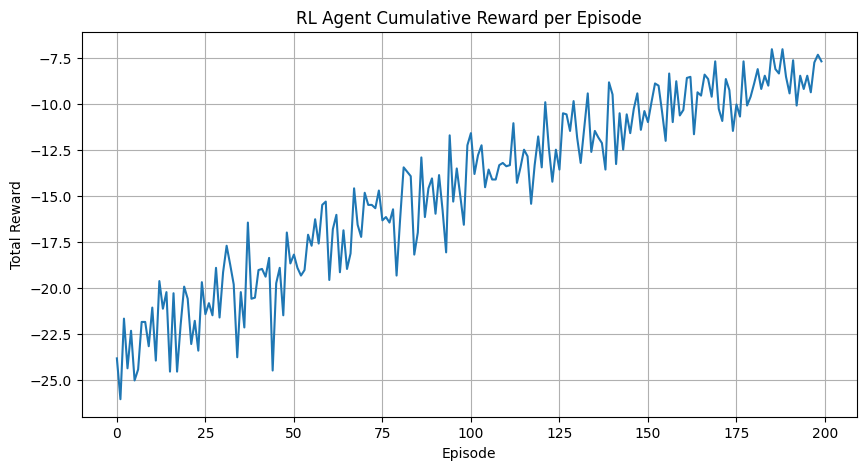

In [24]:
# --- Initialize Environment and Agent ---
# Let's take the first sequence from our test set as the starting point
initial_env_state = X_test_tensor[0].unsqueeze(0)

env = EpidemicEnv(model_v2, initial_env_state, scaler, edge_index, num_states, forecast_horizon)
agent = DQNAgent(state_shape=initial_env_state.shape[1:], num_actions=env.action_space_n)

# --- Training Parameters ---
num_episodes = 200
max_steps_per_episode = 180
batch_size = 32
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
target_update_freq = 10 # Frequency (in episodes) to update the target network

epsilon = epsilon_start
episode_rewards = []

print("Starting RL agent training...")
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    for step in range(max_steps_per_episode):
        # Agent selects an action based on the current state
        action = agent.select_action(state, epsilon)

        # Environment transitions to the next state and returns a reward
        next_state, reward, done = env.step(action)

        # Agent stores this experience and learns from a batch of past experiences
        agent.store_experience(state, action, reward, next_state, done)
        agent.learn(batch_size)

        state = next_state
        total_reward += reward

    episode_rewards.append(total_reward)
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

    # Periodically update the target network for training stability [cite: 178]
    if (episode + 1) % target_update_freq == 0:
        agent.update_target_network()

    if (episode + 1) % 20 == 0:
        print(f"Episode {episode+1}/{num_episodes}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

print("Finished RL Training!")

# --- Plot RL Training Rewards ---
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards)
plt.title('RL Agent Cumulative Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

In [25]:
from google.colab import drive
import os
import joblib

drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/Epidemic_Forecasting_Project/'
os.makedirs(save_path, exist_ok=True)

torch.save(model_v2.state_dict(), os.path.join(save_path, 'gnn_lstm_model.pth'))
print(f"Predictive model saved to: {os.path.join(save_path, 'gnn_lstm_model.pth')}")

torch.save(agent.q_network.state_dict(), os.path.join(save_path, 'rl_agent_q_network.pth'))
print(f"RL agent's Q-Network saved to: {os.path.join(save_path, 'rl_agent_q_network.pth')}")

joblib.dump(scaler, os.path.join(save_path, 'data_scaler.gz'))
print(f"Data scaler saved to: {os.path.join(save_path, 'data_scaler.gz')}")

project_params = {
    'num_states': num_states,
    'lookback_window': lookback_window,
    'forecast_horizon': forecast_horizon,
    'edge_index': edge_index,
    'state_to_idx': state_to_idx
}
torch.save(project_params, os.path.join(save_path, 'project_params.pth'))
print(f"Project parameters saved to: {os.path.join(save_path, 'project_params.pth')}")

print("\nAll files have been successfully exported to your Google Drive. ✅")

Mounted at /content/drive
Predictive model saved to: /content/drive/MyDrive/Epidemic_Forecasting_Project/gnn_lstm_model.pth
RL agent's Q-Network saved to: /content/drive/MyDrive/Epidemic_Forecasting_Project/rl_agent_q_network.pth
Data scaler saved to: /content/drive/MyDrive/Epidemic_Forecasting_Project/data_scaler.gz
Project parameters saved to: /content/drive/MyDrive/Epidemic_Forecasting_Project/project_params.pth

All files have been successfully exported to your Google Drive. ✅
